# Inference of parameters (SIR model)
In this notebook, we consider the SIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 

when given the full data (of classes S, Ia, Is) from a generated trajectory.


In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [3]:
M = 2                # the population has two age groups
N = 5e4              # and this is the total population

# correct params
beta  = 0.02         # infection rate
gIa   = 1./7         # recovery rate of asymptomatic infectives
gIs   = 1./7         # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([0, 0])    # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
true_parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SIR_sto_traj.npy', data_array)

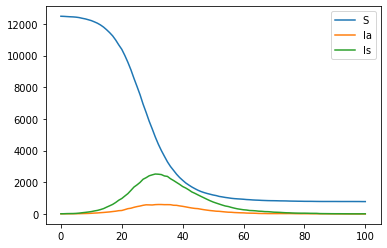

In [4]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

## 2) Inference
We take the first $50$ data points of the trajectories and use it to infer the parameters of the model.

In [5]:
# load the data and rescale to intensive variables 
Tf = 50 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('SIR_sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2116.5487763333967
0.26152729988098145


In [6]:
# Define the prior (Gamma prior around guess of parameter with defined std. deviation)
beta_g = 0.1
beta_std = 0.1
gIa_g = 0.14
gIa_std = 0.05
gIs_g = 0.2
gIs_std = 0.1
alpha_g = 0.3
alpha_std = 0.2

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

50769.89347515993


In [7]:
# inference  
eps = 1e-4   # step size for finite difference computation of Hessian
ftol = 1e-6  # Stopping criterion for minimisation (realtive change in function value)

guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])  # Initial value (and expected value of priors)
bounds = np.array([(eps, 0.8), (eps, 0.2), (eps, 0.6), (eps, 0.6)])  # give some bounds
stds = np.array([alpha_std, beta_std , gIa_std, gIs_std])
start_time = time.time() 
params = estimator.inference(guess, stds, x, Tf, Nf, contactMatrix, bounds=bounds, global_max_iter=40,
                             local_max_iter=200, eps=eps, global_ftol_factor=1e3, ftol=ftol, verbose=True)
end_time = time.time()

print(params) # best guess 
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 4 (seed=920905, Wed May  6 18:43:45 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 1.152261904250683e+03 1.0e+00 1.15e+00  6e-02  2e-01 0:06.4
    2     32 9.065581817484946e+02 1.5e+00 1.06e+00  5e-02  2e-01 0:10.8
    3     48 5.538477969025946e+03 1.6e+00 1.12e+00  6e-02  2e-01 0:15.5
    4     64 -6.342568875996030e+02 2.0e+00 1.07e+00  6e-02  2e-01 0:20.5
    5     80 1.231766792057059e+03 2.4e+00 1.11e+00  5e-02  2e-01 0:24.8
    6     96 6.443046284608283e+03 2.6e+00 9.61e-01  5e-02  2e-01 0:30.6
    8    128 -1.594426095766095e+03 2.8e+00 7.09e-01  4e-02  1e-01 0:39.7
   10    160 5.515645706373339e+02 3.5e+00 7.39e-01  4e-02  1e-01 0:48.8
   12    192 -1.230948018162603e+03 3.9e+00 5.24e-01  2e-02  8e-02 0:57.1
   15    240 -1.119384255381530e+03 3.3e+00 4.09e-01  2e-02  6e-02 1:08.6
   19    304 -1.805903057362910e+03 4.1e+00 2.90e-01  6e-03  3e-02 1:22

In [8]:
# compute log_p for best estimate 
start_time = time.time() 
new_parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa}
logp = estimator.obtain_minus_log_p(new_parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2115.522411427709
0.2668306827545166


In [9]:
hess = estimator.hessian(params, guess, stds, x, Tf, Nf, contactMatrix)
cov = np.linalg.inv(hess)

In [10]:
# if no error, this is positive definite
np.linalg.cholesky(cov)

array([[ 6.61721592e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 4.82071395e-07,  1.13724506e-04,  0.00000000e+00,
         0.00000000e+00],
       [ 4.83936240e-03,  2.30601242e-07,  2.49351855e-03,
         0.00000000e+00],
       [-1.21352996e-03,  3.33359251e-06, -2.77053561e-04,
         9.51949851e-04]])

In [11]:
print("True parameters:")
print(true_parameters)

print("\nInferred parameters:")
print(new_parameters)

True parameters:
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 0.8}

Inferred parameters:
{'alpha': 0.20969266336263118, 'beta': 0.020009641240917767, 'gIa': 0.15080286338749196, 'gIs': 0.14039484235302446, 'fsa': 0.8}
